<a href="https://colab.research.google.com/github/GiangTTran/SparseRandomModeDecomposition/blob/main/examples/music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Music Example

Seperate a short music clip into the flute and guitar instruments using the random feature model in SRMD.

Note the decomposition is *not* found with DBSCAN, and is instead performed by manualy identifying the appropriate frequency cutoff.

This is similar to the example shown in Section 3.5 of the [SRMD paper](https://arxiv.org/abs/2204.06108).

In [1]:
# download module from github
%pip install git+https://github.com/GiangTTran/SparseRandomModeDecomposition.git#egg=srmdpy

  Cloning https://github.com/GiangTTran/SparseRandomModeDecomposition.git to /tmp/pip-install-7o65oyfb/srmdpy_93b20123aa0e435dbc4ab4bc1e0f7f1f
  Running command git clone -q https://github.com/GiangTTran/SparseRandomModeDecomposition.git /tmp/pip-install-7o65oyfb/srmdpy_93b20123aa0e435dbc4ab4bc1e0f7f1f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for srmdpy: filename=srmdpy-0.0.1-py3-none-any.whl size=11216 sha256=05cb3cc4700b12af58cf836ae2cf17bbc60f2a0f41e29a6d0ef589e7964658a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-m22c4x7j/wheels/5b/89/54/7798db729d46561a5ecaef26ca37c2f67537ef21a8c732e2d5
Successfully built srmdpy


Download Music Files

In [2]:
!wget https://github.com/GiangTTran/SparseRandomModeDecomposition/raw/main/data/music.zip
!unzip music.zip

--2022-05-03 21:28:06--  https://github.com/GiangTTran/SparseRandomModeDecomposition/raw/main/data/music.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GiangTTran/SparseRandomModeDecomposition/main/data/music.zip [following]
--2022-05-03 21:28:07--  https://raw.githubusercontent.com/GiangTTran/SparseRandomModeDecomposition/main/data/music.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 419257 (409K) [application/zip]
Saving to: ‘music.zip’

music.zip           100%[===================>] 409.43K  --.-KB/s    in 0.05s   

2022-05-03 21:28:07 (8.78 MB/s) - ‘music.zip’ saved [419257/419257]

Import Files as numpy arrays

In [3]:
import numpy as np
from scipy.io import wavfile
from IPython.display import Audio

# Scalar data type
dtype = np.float32

# Audio file paths
flute_and_guitar_path = '/content/flute_and_guitar.wav'
flute_path  = '/content/only_flute.wav'
guitar_path = '/content/only_guitar.wav'

# Read files
samplerate, both = wavfile.read(flute_and_guitar_path)
_, flute  = wavfile.read(flute_path)
_, guitar = wavfile.read(guitar_path)

# Convert 16-bit signed integer audio to 32-bit floating-point
# i.e. compress [-32768, 32767] to [-1, 1]
scaling = 2**15
both, flute, guitar = map(lambda x: (x / scaling).astype(dtype), [both, flute, guitar])

In [4]:
type(both[0])

numpy.float32

Play audio files

In [5]:
Audio(both, rate=samplerate)

In [6]:
Audio(flute, rate=samplerate)

In [7]:
Audio(guitar, rate=samplerate)

Generate time points for the audio

In [8]:
m = len(both)      # number of samples
L = m / samplerate # length of signal
t = np.linspace(0, L, num=m, endpoint=False, dtype=dtype)

Pre-process audio: equaly downsampled

In [9]:
downsample = 16 # Only use 1/downsample as many samples

def equal_downsample(audio):
    return audio[::downsample]

both_equal, t_equal = map(equal_downsample, [both, t])

Pre-process audio: randomly downsampled

In [10]:
# Create random array with (m/downsample) ones and (m - m/downsample) zeros
np.random.seed(314)
rnd_samples = np.zeros(m).astype(int)
rnd_samples[:int(np.ceil(m/downsample))] = 1 # set first (m/downsample) entries to 1
np.random.shuffle(rnd_samples)               # randomly shuffle

def random_downsample(audio):
    return audio[rnd_samples == 1]

# Note t and both are sampled as the *same* random time points
both_rnd, t_rnd = map(random_downsample, [both, t])

Perform SRMD, where the decomposition is performed by setting a cutoff frequency of 480Hz, on the equaly downsampled signal

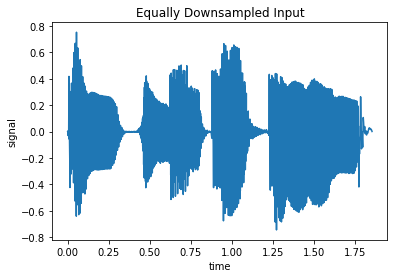

DEBUG:SRMD:N_features = 51080
DEBUG:SRMD:max_frq = 1378.6647420376473
DEBUG:SRMD:eps = 0.37057595252990727
DEBUG:SRMD:frq_scale = 0.0013439668877808578
DEBUG:SRMD:w = 0.03
DEBUG:SRMD:r = 0.1
DEBUG:SRMD:min_samples = 4
DEBUG:SRMD:threshold = 0.2
DEBUG:SRMD:n_modes = None
DEBUG:SRMD:seed = 314
DEBUG:SRMD:m = 5108
DEBUG:SRMD:L = 1.8528797626495361
DEBUG:SRMD:Generating random features...
DEBUG:SRMD:...done!
DEBUG:SRMD:Representing y sparsely in terms of the features...
DEBUG:SRMD:...done!
INFO:SRMD:After thresholding, there are 738 nonzero features out of 51080 features or 1.445%
DEBUG:SRMD:Labelling features by cutoff frequency 480


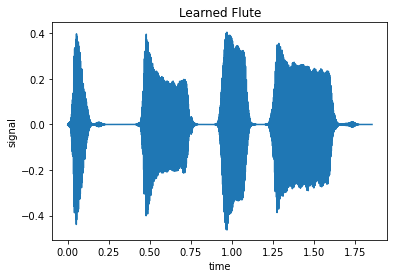

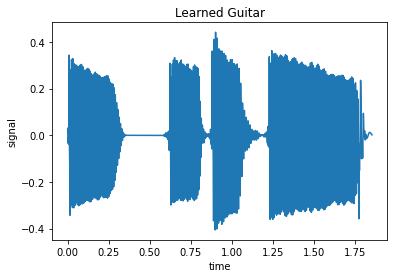

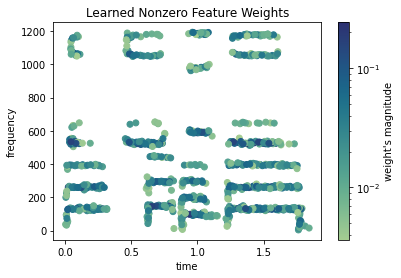

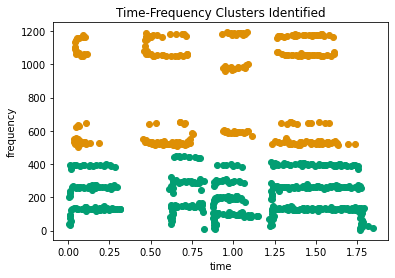

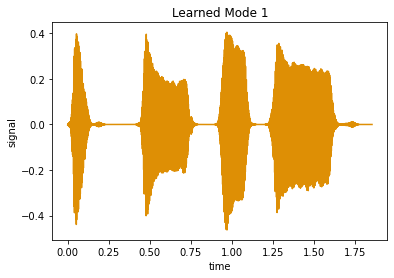

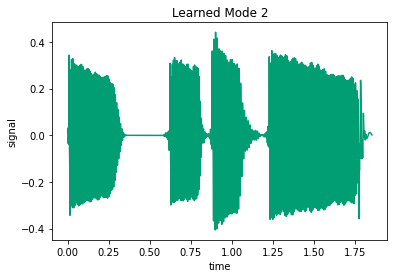

In [11]:
from srmdpy import SRMD
import srmdpy.visualization as plot

plot.signal(t_equal, both_equal, title='Equally Downsampled Input')

# Separate the modes
kwargs_equal = {'N_features': 10*len(t_equal), 'r':0.1, 'w':0.03, 'threshold':0.2,
               'cutoff':480, 'seed':314, 'return_features':True}
modes, (tau, frq, phs), weights, labels = SRMD(both_equal, t_equal, verbosity=2, **kwargs_equal)

# Plot learned modes
print('')
plot.signal(t_equal, modes[:,0], title='Learned Flute')
plot.signal(t_equal, modes[:,1], title='Learned Guitar')

# Plot the learned weights in time frequency space
print('')
plot.weights(tau, frq, weights, labels,
             title='Learned Nonzero Feature Weights')

# Plot the clusters and modes corresponding to those clusters
print('')
plot.modes_with_cluster(t_equal, modes, tau, frq, labels)

In [12]:
from srmdpy.utils import features_from_parameters

def reconstruct_audio(tau, frq, phs, weights, labels, mode_number):
    """Reconstructs the audio clips on fully sampled time points t
    
    Takes the feature parameters and learned weights to re-generate the features
    used in SRMD. Here, the features are sampled on the full time domain t at
    44100 Hz rather than t_equal or t_rnd at 44100/16 Hz
    """
    features = features_from_parameters(t, tau, frq, phs, w=kwargs_equal['w'])
    
    mode_index = np.equal(labels, mode_number)

    y = features[:,mode_index] @ weights[mode_index]
    return y

In [13]:
flute_equal  = reconstruct_audio(tau, frq, phs, weights, labels, mode_number=0)
guitar_equal = reconstruct_audio(tau, frq, phs, weights, labels, mode_number=1)

In [14]:
# Clear unneeded variables
del tau, frq, phs, weights, labels

Repeat the experiment on the randomly downsampled input

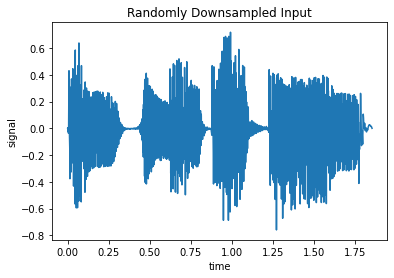

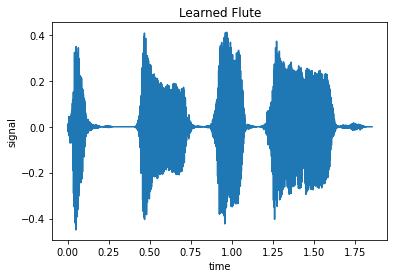

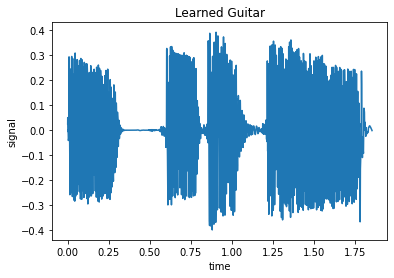

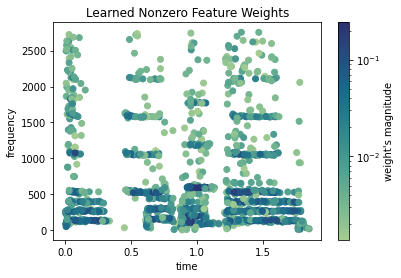

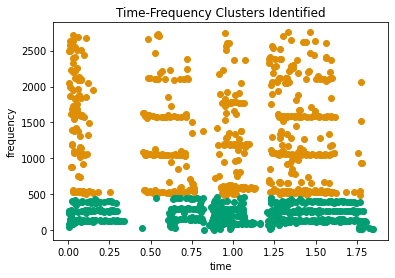

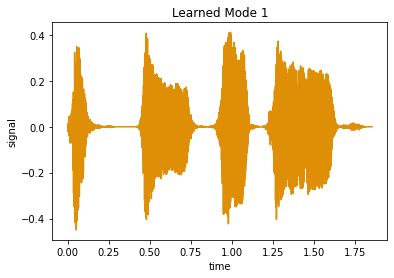

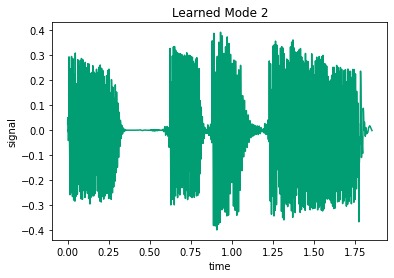

In [15]:
plot.signal(t_rnd, both_rnd, title='Randomly Downsampled Input')

# Separate the modes
kwargs_rnd = kwargs_equal
kwargs_rnd['max_frq'] = len(t_rnd) / L # twice the Nyquist frequency
modes, (tau, frq, phs), weights, labels = SRMD(both_rnd, t_rnd, **kwargs_rnd)

# Plot learned modes
print('')
plot.signal(t_equal, modes[:,0], title='Learned Flute')
plot.signal(t_equal, modes[:,1], title='Learned Guitar')

# Plot the learned weights in time frequency space
print('')
plot.weights(tau, frq, weights, labels,
             title='Learned Nonzero Feature Weights')

# Plot the clusters and modes corresponding to those clusters
print('')
plot.modes_with_cluster(t_rnd, modes, tau, frq, labels)

In [16]:
flute_rnd  = reconstruct_audio(tau, frq, phs, weights, labels, mode_number=0)
guitar_rnd = reconstruct_audio(tau, frq, phs, weights, labels, mode_number=1)

Compare learned flute and guitar audio

In [17]:
Audio(flute,  rate=samplerate)

In [18]:
Audio(guitar, rate=samplerate)

In [19]:
Audio(flute_equal,  rate=samplerate)

In [20]:
Audio(guitar_equal, rate=samplerate)

In [21]:
Audio(flute_rnd,  rate=samplerate)

In [22]:
Audio(guitar_rnd, rate=samplerate)

Visualize difference between ground truth and reconstructed flute 

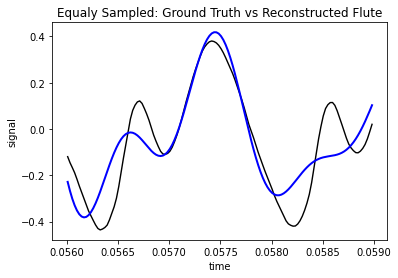

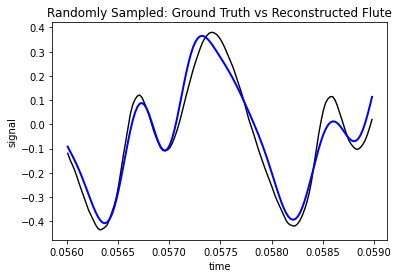

In [23]:
import matplotlib.pyplot as plt

# Plotting Parameters
left_endpoint, right_endpoint = 0.056, 0.059 # in seconds
domain = (left_endpoint < t) & (t < right_endpoint)
reconstructed_transparency = 0.8
truth_linewidth = 1.4
truth_colour = 'k'
reconstructed_linewidth = 2
reconstructed_colour = 'b'

def plot_compare_with_original(reconstructed_signal, title):
    fig = plt.figure()
    plt.title(title)
    plt.xlabel("time")
    plt.ylabel("signal")

    # Ground Truth
    plt.plot(t[domain], flute[domain], truth_colour, linewidth=truth_linewidth)

    # Reconstructed
    plt.plot(t[domain], reconstructed_signal[domain], reconstructed_colour,
            linewidth=reconstructed_linewidth)


plot_compare_with_original(flute_equal,
    title="Equaly Sampled: Ground Truth vs Reconstructed Flute")

plot_compare_with_original(flute_rnd,
    title="Randomly Sampled: Ground Truth vs Reconstructed Flute")